In [1]:
# PROJECT DESCRIPTION

# As the county director for social services, I want to determine if there is a correlation between 
# the dominant characteristics of a neighborhood, in this case defined by ZIP code, and the occurrence of 
# substantiated child abuse reports. Looking at the top 5 venues, I want to see if there is a relationship 
# across neighborhoods/ZIP codes and the percentage of reports per capita to properly allocate 
# county resources and community resources. The county in question is Sacramento, CA. 

In [2]:
# PROPOSED DATA ELEMENTS

# For this study, I will be using aggregate Social Services data from Sacramento, CA. I'll be using the 
# number of referrals (Child Abuse Reports) by ZIP code for calendar year 2018. This non-PI aggregate 
# data will be extracted from child welfare data. 

# I'll also use data available from https://www.california-demographics.com/zip_codes_by_population to 
# compare the number of referrals to social services to the overall population to get a 
# per capita density measure. 

# I'll be using FourSquare to categorize the ZIP code areas by their top 5 venues or features and cross referencing
# referral data to above social services incident data to see if the venues or features of a neighborhood are 
# predictive of the liklihood for social services referrals and to use that data to pro-actively allocate 
# resources if possible. 

In [3]:
# Import referral data from csv
import types
import pandas as pd
import numpy as np
from botocore.client import Config
import ibm_boto3
import matplotlib as mp
import matplotlib.cm as cm
import matplotlib.colors as colors
#!conda install -c conda-forge folium=0.5.0 --yes
#import folium
import json

def __iter__(self): return 0

# Import the referral data

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share your notebook.
client_d63e63400afe4f92971e3fe186fde932 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='OAgIK7qHRzC1zourJz4MD2o_p7i-NiriW9AGA8qyAa8Y',
    ibm_auth_endpoint="https://iam.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_d63e63400afe4f92971e3fe186fde932.get_object(Bucket='mydatascienceproject-donotdelete-pr-ohltd7mgwkejxm',Key='data_asset/Referral_by_ZIP.csv_shaped_8MnI3QfmSt2R5jou6oJn1A.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_referral = pd.read_csv(body)
df_referral.head



<bound method NDFrame.head of       ZIP  Referrals
0   95602        1.0
1   95608      131.0
2   95610      212.0
3   95621      163.0
4   95624      128.0
5   95626        3.0
6   95628       59.0
7   95630       64.0
8   95632       68.0
9   95638        2.0
10  95641        3.0
11  95652       13.0
12  95655       15.0
13  95660      155.0
14  95662       54.0
15  95667        2.0
16  95670      184.0
17  95673       62.0
18  95678        2.0
19  95682        2.0
20  95690        9.0
21  95693        8.0
22  95742       32.0
23  95757       50.0
24  95758      123.0
25  95811       39.0
26  95812        5.0
27  95814       23.0
28  95815      191.0
29  95816       24.0
30  95817       60.0
31  95818       71.0
32  95819       15.0
33  95820      154.0
34  95821      221.0
35  95822      161.0
36  95823      464.0
37  95824      194.0
38  95825      162.0
39  95826      117.0
40  95827      108.0
41  95828      186.0
42  95829       43.0
43  95831      100.0
44  95832       61.0
45  

In [4]:
# Import the population data

body = client_d63e63400afe4f92971e3fe186fde932.get_object(Bucket='mydatascienceproject-donotdelete-pr-ohltd7mgwkejxm',Key='data_asset/Sac_ZIP_Population_geocode.csv_shaped_6rbcZ3r1QtugcShNC41xYA.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_pop = pd.read_csv(body)
df_pop.head()


,ZIP,City,Population,Latitude,Longitude
0,95608,Carmichael,59418.0,38.621360,-121.332191
1,95610,Citrus Heights,44147.0,38.689802,-121.267360
2,95615,Courtland,834.0,38.338322,-121.537800
3,95621,Citrus Heights,39819.0,38.693052,-121.309461
4,95624,Elk Grove,61989.0,38.441480,-121.307142


In [5]:
# Merge the referral and population frames

df = pd.merge(df_referral, df_pop, on='ZIP', how='inner')
df.head()

,ZIP,Referrals,City,Population,Latitude,Longitude
0,95608,131.0,Carmichael,59418.0,38.621360,-121.332191
1,95610,212.0,Citrus Heights,44147.0,38.689802,-121.267360
2,95621,163.0,Citrus Heights,39819.0,38.693052,-121.309461
3,95624,128.0,Elk Grove,61989.0,38.441480,-121.307142
4,95626,3.0,Elverta,5975.0,38.713790,-121.462730


In [6]:
# Calculate the referral to poulation ratio

df['Density']=df['Referrals']/df['Population']
df.head()

,ZIP,Referrals,City,Population,Latitude,Longitude,Density
0,95608,131.0,Carmichael,59418.0,38.621360,-121.332191,0.002205
1,95610,212.0,Citrus Heights,44147.0,38.689802,-121.267360,0.004802
2,95621,163.0,Citrus Heights,39819.0,38.693052,-121.309461,0.004094
3,95624,128.0,Elk Grove,61989.0,38.441480,-121.307142,0.002065
4,95626,3.0,Elverta,5975.0,38.713790,-121.462730,0.000502


In [7]:
# Sacramento Geo 

sac_lat = 38.5816 
sac_lon = -121.4944
map_sac = folium.Map(location=[sac_lat, sac_lon], zoom_start=12)

for lat, lng, city, ZIP in zip(df['Latitude'], df['Longitude'], df['City'],df['ZIP']):
    label = '{}, {}'.format(city, ZIP)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_sac)

map_sac

NameError: name 'folium' is not defined

In [8]:
#FourSquare Info

CLIENT_ID = 'P55ZSLKQNZJYISSRDA1DAD1VONS5ZEFMO05L3AWTYED5YXSL' # your Foursquare ID
CLIENT_SECRET = 'UCNJEBTYKKQ3ZCFN3H3DJXJZUK1FVHNIOQNQYR3PLQAS1LPU' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: P55ZSLKQNZJYISSRDA1DAD1VONS5ZEFMO05L3AWTYED5YXSL
CLIENT_SECRET:UCNJEBTYKKQ3ZCFN3H3DJXJZUK1FVHNIOQNQYR3PLQAS1LPU


In [9]:
df.loc[0, 'City']

#Get the neighborhood's latitude and longitude values.

neighborhood_latitude = df.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = df.loc[0, 'Longitude'] # neighborhood longitude value
neighborhood_name = df.loc[0, 'City'] # neighborhood name
print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name,
                                                            neighborhood_latitude,
                                                            neighborhood_longitude))


#Top 100 Venues within 500m of Marble Hill
radius = 500
LIMIT = 100


url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(
    CLIENT_ID,
    CLIENT_SECRET,
    neighborhood_latitude,
    neighborhood_longitude,
    VERSION,
    radius,
    LIMIT)

url


Latitude and longitude values of Carmichael are 38.621359999999996, -121.332191.


'https://api.foursquare.com/v2/venues/explore?client_id=P55ZSLKQNZJYISSRDA1DAD1VONS5ZEFMO05L3AWTYED5YXSL&client_secret=UCNJEBTYKKQ3ZCFN3H3DJXJZUK1FVHNIOQNQYR3PLQAS1LPU&ll=38.621359999999996,-121.332191&v=20180605&radius=500&limit=100'

In [10]:
import requests
from pandas.io.json import json_normalize
from sklearn.cluster import KMeans

results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5d000932351e3d12837019a9'},
 'response': {'groups': [{'items': [{'reasons': {'count': 0,
       'items': [{'reasonName': 'globalInteractionReason',
         'summary': 'This spot is popular',
         'type': 'general'}]},
      'referralId': 'e-0-4d44cdb12e326ea8d735e8a6-0',
      'venue': {'categories': [{'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_',
          'suffix': '.png'},
         'id': '4bf58dd8d48988d1ca941735',
         'name': 'Pizza Place',
         'pluralName': 'Pizza Places',
         'primary': True,
         'shortName': 'Pizza'}],
       'id': '4d44cdb12e326ea8d735e8a6',
       'location': {'address': '6530 Fair Oaks Blvd',
        'cc': 'US',
        'city': 'Carmichael',
        'country': 'United States',
        'distance': 387,
        'formattedAddress': ['6530 Fair Oaks Blvd',
         'Carmichael, CA 95608',
         'United States'],
        'labeledLatLngs': [{'label': 'display',
          'la

In [11]:
# function that extracts the category of the venue

def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
    
venues = results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues) # flatten JSON


# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]


# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)


# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]


print(nearby_venues.head())


#How many venues were returned by FourSquare?

print()
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

                     name        categories        lat         lng
0            Roma's Pizza       Pizza Place  38.619713 -121.328264
1           Papa Murphy's       Pizza Place  38.619083 -121.328062
2    99 Cents Only Stores    Discount Store  38.618010 -121.329878
3  Les Schwab Tire Center   Automotive Shop  38.620269 -121.328096
4                Yianni's  Greek Restaurant  38.621531 -121.328074

9 venues were returned by Foursquare.


In [12]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):

    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)

        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION,
            lat,
            lng,
            radius,
            LIMIT)

        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']

        # return only relevant information for each nearby venue
        venues_list.append([(
            name,
            lat,
            lng,
            v['venue']['name'],
            v['venue']['location']['lat'],
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['name']) for v in results])

        nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
        nearby_venues.columns = ['City',
                'City Latitude',
                'City Longitude',
                'Venue',
                'Venue Latitude',
                'Venue Longitude',
                'Venue Category']

    return(nearby_venues)

sac_venues = getNearbyVenues(names=df['City'],
                                    latitudes=df['Latitude'],
                                    longitudes=df['Longitude']
                            )


print(sac_venues.shape)
sac_venues.head()

Carmichael
Citrus Heights
Citrus Heights
Elk Grove
Elverta
Fair Oaks
Folsom
Galt
Herald
Isleton
Mcclellan
Mather
North Highlands
Orangevale
Rancho Cordova
Rio Linda
Walnut Grove
Wilton
Rancho Cordova
Elk Grove
Elk Grove
Sacramento
Sacramento
Sacramento
Sacramento
Sacramento
Sacramento
Sacramento
Sacramento
Sacramento
Sacramento
Sacramento
Sacramento
Sacramento
Sacramento
Sacramento
Sacramento
Sacramento
Sacramento
Sacramento
Sacramento
Sacramento
Sacramento
Sacramento
Sacramento
Sacramento
Antelope
Sacramento
(443, 7)


,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Carmichael,38.62136,-121.332191,Roma's Pizza,38.619713,-121.328264,Pizza Place
1,Carmichael,38.62136,-121.332191,Papa Murphy's,38.619083,-121.328062,Pizza Place
2,Carmichael,38.62136,-121.332191,99 Cents Only Stores,38.618010,-121.329878,Discount Store
3,Carmichael,38.62136,-121.332191,Les Schwab Tire Center,38.620269,-121.328096,Automotive Shop
4,Carmichael,38.62136,-121.332191,Yianni's,38.621531,-121.328074,Greek Restaurant


In [13]:
sac_venues.groupby('City').count()

,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
City,,,,,,
Antelope,36,36,36,36,36,36
Carmichael,9,9,9,9,9,9
Citrus Heights,14,14,14,14,14,14
Elk Grove,52,52,52,52,52,52
Elverta,3,3,3,3,3,3
Fair Oaks,4,4,4,4,4,4
Folsom,3,3,3,3,3,3
Galt,9,9,9,9,9,9
Herald,1,1,1,1,1,1


In [14]:
print('There are {} uniques categories in Sacramento.'.format(len(sac_venues['Venue Category'].unique())))

There are 151 uniques categories in Sacramento.


In [15]:
sac_onehot = pd.get_dummies(sac_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
sac_onehot['City'] = sac_venues['City']

# move neighborhood column to the first column
fixed_columns = [sac_onehot.columns[-1]] + list(sac_onehot.columns[:-1])
sac_onehot = sac_onehot[fixed_columns]

sac_onehot.head()

,City,ATM,Afghan Restaurant,Airport,Airport Terminal,American Restaurant,Antique Shop,Arts & Crafts Store,Asian Restaurant,Automotive Shop,...,Thrift / Vintage Store,Trail,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Winery,Wings Joint,Women's Store
0,Carmichael,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Carmichael,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Carmichael,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Carmichael,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,Carmichael,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
sac_grouped = sac_onehot.groupby('City').mean().reset_index()
sac_grouped

,City,ATM,Afghan Restaurant,Airport,Airport Terminal,American Restaurant,Antique Shop,Arts & Crafts Store,Asian Restaurant,Automotive Shop,...,Thrift / Vintage Store,Trail,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Winery,Wings Joint,Women's Store
0,Antelope,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.027778,...,0.000000,0.000000,0.000000,0.027778,0.027778,0.000000,0.000000,0.000000,0.055556,0.000000
1,Carmichael,0.000000,0.000000,0.000000,0.000000,0.000000,0.111111,0.000000,0.000000,0.111111,...,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Citrus Heights,0.071429,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Elk Grove,0.000000,0.038462,0.000000,0.000000,0.019231,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.019231,0.000000,0.000000,0.019231
4,Elverta,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,Fair Oaks,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,Folsom,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,Galt,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,Herald,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,Isleton,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [17]:
num_top_venues = 5


for hood in sac_grouped['City']:
    print("----"+hood+"----")
    temp = sac_grouped[sac_grouped['City'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Antelope----
                venue  freq
0         Pizza Place  0.17
1  Mexican Restaurant  0.08
2         Supermarket  0.06
3         Wings Joint  0.06
4         Coffee Shop  0.03


----Carmichael----
                     venue  freq
0              Pizza Place  0.22
1  Health & Beauty Service  0.11
2           Discount Store  0.11
3             Antique Shop  0.11
4          Automotive Shop  0.11


----Citrus Heights----
             venue  freq
0   Cosmetics Shop  0.14
1              ATM  0.07
2  Thai Restaurant  0.07
3       Playground  0.07
4   Discount Store  0.07


----Elk Grove----
                  venue  freq
0  Fast Food Restaurant  0.08
1           Pizza Place  0.06
2        Shipping Store  0.04
3        Cosmetics Shop  0.04
4    Italian Restaurant  0.04


----Elverta----
                     venue  freq
0                Pet Store  0.67
1             Home Service  0.33
2                      ATM  0.00
3  New American Restaurant  0.00
4                    Motel  0.00


---

In [18]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#Now let's create the new dataframe and display the top 10 venues for each neighborhood.

num_top_venues = 5


indicators = ['st', 'nd', 'rd']


# create columns according to number of top venues
columns = ['City']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{}_Most_Common_Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th_Most_Common_Venue'.format(ind+1))


# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['City'] = sac_grouped['City']


for ind in np.arange(sac_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(sac_grouped.iloc[ind, :], num_top_venues)


# neighborhoods_venues_sorted.head()
neighborhoods_venues_sorted

,City,1st_Most_Common_Venue,2nd_Most_Common_Venue,3rd_Most_Common_Venue,4th_Most_Common_Venue,5th_Most_Common_Venue
0,Antelope,Pizza Place,Mexican Restaurant,Wings Joint,Supermarket,Ice Cream Shop
1,Carmichael,Pizza Place,Antique Shop,Martial Arts Dojo,Greek Restaurant,Automotive Shop
2,Citrus Heights,Cosmetics Shop,Bank,Convenience Store,Park,Pizza Place
3,Elk Grove,Fast Food Restaurant,Pizza Place,Cosmetics Shop,Rental Car Location,Italian Restaurant
4,Elverta,Pet Store,Home Service,Women's Store,Donut Shop,Fishing Store
5,Fair Oaks,Liquor Store,Home Service,Convenience Store,Construction & Landscaping,Women's Store
6,Folsom,Gym,Trail,Women's Store,Donut Shop,Flea Market
7,Galt,Fast Food Restaurant,Motel,Intersection,Steakhouse,Print Shop
8,Herald,Construction & Landscaping,Women's Store,Donut Shop,Flea Market,Fishing Store
9,Isleton,Mexican Restaurant,Convenience Store,Fishing Store,Steakhouse,Electronics Store


In [19]:
# CLuster the City Data
from sklearn.cluster import KMeans

kclusters = 5
sac_grouped_clustering = sac_grouped.drop('City', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(sac_grouped_clustering)


# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]


# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster_Label', kmeans.labels_)

neighborhoods_venues_sorted

,Cluster_Label,City,1st_Most_Common_Venue,2nd_Most_Common_Venue,3rd_Most_Common_Venue,4th_Most_Common_Venue,5th_Most_Common_Venue
0,0,Antelope,Pizza Place,Mexican Restaurant,Wings Joint,Supermarket,Ice Cream Shop
1,0,Carmichael,Pizza Place,Antique Shop,Martial Arts Dojo,Greek Restaurant,Automotive Shop
2,0,Citrus Heights,Cosmetics Shop,Bank,Convenience Store,Park,Pizza Place
3,0,Elk Grove,Fast Food Restaurant,Pizza Place,Cosmetics Shop,Rental Car Location,Italian Restaurant
4,3,Elverta,Pet Store,Home Service,Women's Store,Donut Shop,Fishing Store
5,0,Fair Oaks,Liquor Store,Home Service,Convenience Store,Construction & Landscaping,Women's Store
6,4,Folsom,Gym,Trail,Women's Store,Donut Shop,Flea Market
7,0,Galt,Fast Food Restaurant,Motel,Intersection,Steakhouse,Print Shop
8,2,Herald,Construction & Landscaping,Women's Store,Donut Shop,Flea Market,Fishing Store
9,0,Isleton,Mexican Restaurant,Convenience Store,Fishing Store,Steakhouse,Electronics Store


In [20]:
df_merge = pd.merge(df, neighborhoods_venues_sorted, on='City', how='inner')
df_merge.head()

,ZIP,Referrals,City,Population,Latitude,Longitude,Density,Cluster_Label,1st_Most_Common_Venue,2nd_Most_Common_Venue,3rd_Most_Common_Venue,4th_Most_Common_Venue,5th_Most_Common_Venue
0,95608,131.0,Carmichael,59418.0,38.621360,-121.332191,0.002205,0,Pizza Place,Antique Shop,Martial Arts Dojo,Greek Restaurant,Automotive Shop
1,95610,212.0,Citrus Heights,44147.0,38.689802,-121.267360,0.004802,0,Cosmetics Shop,Bank,Convenience Store,Park,Pizza Place
2,95621,163.0,Citrus Heights,39819.0,38.693052,-121.309461,0.004094,0,Cosmetics Shop,Bank,Convenience Store,Park,Pizza Place
3,95624,128.0,Elk Grove,61989.0,38.441480,-121.307142,0.002065,0,Fast Food Restaurant,Pizza Place,Cosmetics Shop,Rental Car Location,Italian Restaurant
4,95757,50.0,Elk Grove,40222.0,38.409138,-121.377749,0.001243,0,Fast Food Restaurant,Pizza Place,Cosmetics Shop,Rental Car Location,Italian Restaurant


In [21]:
#Examine Cluster 1
df_merge.loc[df_merge['Cluster_Label'] == 0, df_merge.columns[[1] + list(range(5, df_merge.shape[1]))]]


,Referrals,Longitude,Density,Cluster_Label,1st_Most_Common_Venue,2nd_Most_Common_Venue,3rd_Most_Common_Venue,4th_Most_Common_Venue,5th_Most_Common_Venue
0,131.0,-121.332191,0.002205,0,Pizza Place,Antique Shop,Martial Arts Dojo,Greek Restaurant,Automotive Shop
1,212.0,-121.267360,0.004802,0,Cosmetics Shop,Bank,Convenience Store,Park,Pizza Place
2,163.0,-121.309461,0.004094,0,Cosmetics Shop,Bank,Convenience Store,Park,Pizza Place
3,128.0,-121.307142,0.002065,0,Fast Food Restaurant,Pizza Place,Cosmetics Shop,Rental Car Location,Italian Restaurant
4,50.0,-121.377749,0.001243,0,Fast Food Restaurant,Pizza Place,Cosmetics Shop,Rental Car Location,Italian Restaurant
5,123.0,-121.414768,0.002035,0,Fast Food Restaurant,Pizza Place,Cosmetics Shop,Rental Car Location,Italian Restaurant
7,59.0,-121.260709,0.001468,0,Liquor Store,Home Service,Convenience Store,Construction & Landscaping,Women's Store
9,68.0,-121.313883,0.002323,0,Fast Food Restaurant,Motel,Intersection,Steakhouse,Print Shop
11,3.0,-121.611620,0.001511,0,Mexican Restaurant,Convenience Store,Fishing Store,Steakhouse,Electronics Store
12,13.0,-121.389613,0.017591,0,Convenience Store,Grocery Store,Fast Food Restaurant,Café,Sandwich Place


In [22]:
#Examine Cluster 2

df_merge.loc[df_merge['Cluster_Label'] == 1, df_merge.columns[[1] + list(range(5, df_merge.shape[1]))]]


,Referrals,Longitude,Density,Cluster_Label,1st_Most_Common_Venue,2nd_Most_Common_Venue,3rd_Most_Common_Venue,4th_Most_Common_Venue,5th_Most_Common_Venue
18,9.0,-121.50835,0.003553,1,Food Truck,Women's Store,Electronics Store,Flea Market,Fishing Store


In [23]:
#Examine Cluster 3

df_merge.loc[df_merge['Cluster_Label'] == 2, df_merge.columns[[1] + list(range(5, df_merge.shape[1]))]]

,Referrals,Longitude,Density,Cluster_Label,1st_Most_Common_Venue,2nd_Most_Common_Venue,3rd_Most_Common_Venue,4th_Most_Common_Venue,5th_Most_Common_Venue
10,2.0,-121.154808,0.000887,2,Construction & Landscaping,Women's Store,Donut Shop,Flea Market,Fishing Store


In [24]:
#Examine Cluster 4

df_merge.loc[df_merge['Cluster_Label'] == 3, df_merge.columns[[1] + list(range(5, df_merge.shape[1]))]]

,Referrals,Longitude,Density,Cluster_Label,1st_Most_Common_Venue,2nd_Most_Common_Venue,3rd_Most_Common_Venue,4th_Most_Common_Venue,5th_Most_Common_Venue
6,3.0,-121.46273,0.000502,3,Pet Store,Home Service,Women's Store,Donut Shop,Fishing Store


In [25]:
#Examine Cluster 5

df_merge.loc[df_merge['Cluster_Label'] == 4, df_merge.columns[[1] + list(range(5, df_merge.shape[1]))]]

,Referrals,Longitude,Density,Cluster_Label,1st_Most_Common_Venue,2nd_Most_Common_Venue,3rd_Most_Common_Venue,4th_Most_Common_Venue,5th_Most_Common_Venue
8,64.0,-121.141636,0.000887,4,Gym,Trail,Women's Store,Donut Shop,Flea Market
19,8.0,-121.239026,0.001184,4,Gym,Women's Store,Donut Shop,Flea Market,Fishing Store


In [26]:
df_sort = df_merge.sort_values(by='Density', ascending=False)
df_sort

,ZIP,Referrals,City,Population,Latitude,Longitude,Density,Cluster_Label,1st_Most_Common_Venue,2nd_Most_Common_Venue,3rd_Most_Common_Venue,4th_Most_Common_Venue,5th_Most_Common_Venue
12,95652,13.0,Mcclellan,739.0,38.666653,-121.389613,0.017591,0,Convenience Store,Grocery Store,Fast Food Restaurant,Café,Sandwich Place
22,95815,191.0,Sacramento,24680.0,38.589505,-121.448665,0.007739,0,Coffee Shop,Park,Hotel,Mexican Restaurant,American Restaurant
42,95838,276.0,Sacramento,36764.0,38.645103,-121.440015,0.007507,0,Coffee Shop,Park,Hotel,Mexican Restaurant,American Restaurant
28,95821,221.0,Sacramento,33550.0,38.625693,-121.384916,0.006587,0,Coffee Shop,Park,Hotel,Mexican Restaurant,American Restaurant
31,95824,194.0,Sacramento,30221.0,38.517256,-121.440764,0.006419,0,Coffee Shop,Park,Hotel,Mexican Restaurant,American Restaurant
30,95823,464.0,Sacramento,73985.0,38.481354,-121.442071,0.006272,0,Coffee Shop,Park,Hotel,Mexican Restaurant,American Restaurant
34,95827,108.0,Sacramento,20269.0,38.552752,-121.322653,0.005328,0,Coffee Shop,Park,Hotel,Mexican Restaurant,American Restaurant
32,95825,162.0,Sacramento,31084.0,38.585804,-121.402213,0.005212,0,Coffee Shop,Park,Hotel,Mexican Restaurant,American Restaurant
20,95811,39.0,Sacramento,7595.0,38.583230,-121.478101,0.005135,0,Coffee Shop,Park,Hotel,Mexican Restaurant,American Restaurant
38,95832,61.0,Sacramento,11924.0,38.435014,-121.497276,0.005116,0,Coffee Shop,Park,Hotel,Mexican Restaurant,American Restaurant


In [27]:
# Determine if there is a reltionship between cluster and density. Does the type of area (cluster) determine the number of referals
# per capita?

import matplotlib.pyplot as plt

plt.scatter(df_sort.Cluster_Label, df_sort.Density, color='blue')
plt.xlabel("Label")
plt.ylabel("Density")
plt.show()

In [28]:
#Setting up the Split
msk = np.random.rand(len(df_sort)) < 0.8
train = df_sort[msk]
test = df_sort[~msk]

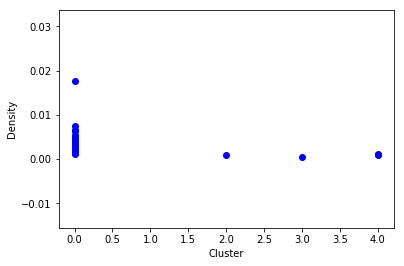

In [29]:
#Train Data Distribution
plt.scatter(train.Cluster_Label, train.Density, color='blue')
plt.xlabel("Cluster")
plt.ylabel("Density")
plt.show()

In [30]:
#Learning the Data
from sklearn import linear_model
regr = linear_model.LinearRegression()
train_x = np.asanyarray(train[['Cluster_Label']])
train_y = np.asanyarray(train[['Density']])


regr.fit (train_x, train_y)
# The coefficients
print ('Coefficients: ', regr.coef_)
print ('Intercept: ',regr.intercept_)

Coefficients:  [[-0.00095876]]
Intercept:  [ 0.00420817]


Text(0,0.5,'Density')

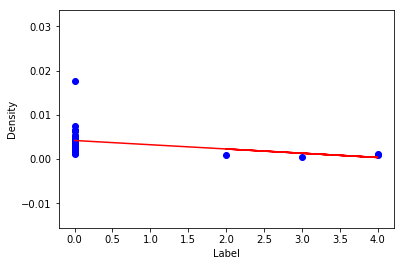

In [31]:
#Plot the Data
plt.scatter(train.Cluster_Label, train.Density, color='blue')
plt.plot(train_x, regr.coef_[0][0]*train_x + regr.intercept_[0], '-r')
plt.xlabel("Label")
plt.ylabel("Density")

In [32]:
#Evaluate the Model
from sklearn.metrics import r2_score

test_x = np.asanyarray(test[['Cluster_Label']])
test_y = np.asanyarray(test[['Density']])
test_y_hat = regr.predict(test_x)

print("Mean absolute error: %.2f" % np.mean(np.absolute(test_y_hat - test_y)))
print("Residual sum of squares (MSE): %.2f" % np.mean((test_y_hat - test_y) ** 2))
print("R2-score: %.2f" % r2_score(test_y_hat , test_y) )

Mean absolute error: 0.00
Residual sum of squares (MSE): 0.00
R2-score: -64.99


In [107]:
#Since the line is pretty flat for the relaionship between Venue and Density, I decided to look at the weighted values for the
#venues, giving 5 to 1st and 1 to 5th etc. I then summed the weighted ranks and grouped by venue to give each venue a weight
#based on it common order (1-5) and it's density for that location/ZIP. 

In [34]:
df_sort.head()

,ZIP,Referrals,City,Population,Latitude,Longitude,Density,Cluster_Label,1st_Most_Common_Venue,2nd_Most_Common_Venue,3rd_Most_Common_Venue,4th_Most_Common_Venue,5th_Most_Common_Venue
12,95652,13.0,Mcclellan,739.0,38.666653,-121.389613,0.017591,0,Convenience Store,Grocery Store,Fast Food Restaurant,Café,Sandwich Place
22,95815,191.0,Sacramento,24680.0,38.589505,-121.448665,0.007739,0,Coffee Shop,Park,Hotel,Mexican Restaurant,American Restaurant
42,95838,276.0,Sacramento,36764.0,38.645103,-121.440015,0.007507,0,Coffee Shop,Park,Hotel,Mexican Restaurant,American Restaurant
28,95821,221.0,Sacramento,33550.0,38.625693,-121.384916,0.006587,0,Coffee Shop,Park,Hotel,Mexican Restaurant,American Restaurant
31,95824,194.0,Sacramento,30221.0,38.517256,-121.440764,0.006419,0,Coffee Shop,Park,Hotel,Mexican Restaurant,American Restaurant


In [35]:
#Create a table for the 1st most common venues and their weights - repeat for all 5 common categories
v1=df_sort.loc[:,["1st_Most_Common_Venue","Density"]]
v1['wt'] = v1['Density']*5
v1.columns=['Venue','Density','wt']
v1s = v1.groupby(['Venue']).sum()
v1s

,Density,wt
Venue,,
Coffee Shop,0.105384,0.526918
Construction & Landscaping,0.000887,0.004435
Convenience Store,0.017591,0.087957
Cosmetics Shop,0.008896,0.044478
Fast Food Restaurant,0.007667,0.038333
Food Truck,0.003553,0.017765
Gym,0.002070,0.010352
Liquor Store,0.001468,0.007339
Mexican Restaurant,0.014160,0.070801


In [36]:
v2=df_sort.loc[:,["2nd_Most_Common_Venue","Density"]]
v2['wt'] = v2['Density']*4
v2.columns=['Venue','Density','wt']
v2s = v2.groupby(['Venue']).sum()
v2s

,Density,wt
Venue,,
Antique Shop,0.002205,0.008819
Automotive Shop,0.007603,0.030412
Bank,0.008896,0.035583
Convenience Store,0.001511,0.006042
Cuban Restaurant,0.005047,0.020186
Grocery Store,0.021603,0.086412
Home Service,0.001970,0.007880
Mexican Restaurant,0.001865,0.007459
Motel,0.002323,0.009293


In [37]:
v3=df_sort.loc[:,["3rd_Most_Common_Venue","Density"]]
v3['wt'] = v3['Density']*3
v3.columns=['Venue','Density','wt']
v3s = v3.groupby(['Venue']).sum()
v3s

,Density,wt
Venue,,
Asian Restaurant,0.005047,0.015140
Convenience Store,0.014375,0.043125
Cosmetics Shop,0.005343,0.016030
Donut Shop,0.002071,0.006212
Electronics Store,0.003553,0.010659
Fast Food Restaurant,0.017591,0.052774
Fish & Chips Shop,0.007603,0.022809
Fishing Store,0.001511,0.004532
Hotel,0.105384,0.316151


In [38]:
v4=df_sort.loc[:,["4th_Most_Common_Venue","Density"]]
v4['wt'] = v4['Density']*2
v4.columns=['Venue','Density','wt']
v4s = v4.groupby(['Venue']).sum()
v4s

,Density,wt
Venue,,
Café,0.017591,0.035183
Coffee Shop,0.004012,0.008023
Construction & Landscaping,0.001468,0.002936
Dance Studio,0.007603,0.015206
Donut Shop,0.001389,0.002778
Electronics Store,0.001711,0.003422
Flea Market,0.005624,0.011248
Greek Restaurant,0.002205,0.004409
Mexican Restaurant,0.105384,0.210767


In [39]:
v5=df_sort.loc[:,["5th_Most_Common_Venue","Density"]]
v5['wt'] = v5['Density']*1
v5.columns=['Venue','Density','wt']
v5s = v5.groupby(['Venue']).sum()
v5s

,Density,wt
Venue,,
American Restaurant,0.105384,0.105384
Automotive Shop,0.002205,0.002205
Dive Bar,0.001711,0.001711
Electronics Store,0.001511,0.001511
Fast Food Restaurant,0.004012,0.004012
Fishing Store,0.006126,0.006126
Flea Market,0.000887,0.000887
Historic Site,0.007603,0.007603
Ice Cream Shop,0.001865,0.001865


In [40]:
#combine the ranked and weighted venue tables into one and group by the venue to get a combined weighted score 
venue_rank = pd.concat([v1s,v2s,v3s,v4s,v5s])
venue_rank = venue_rank.groupby(['Venue']).sum()
venue_rank = venue_rank.sort_values(['wt'],ascending=False)
venue_rank

,Density,wt
Venue,,
Coffee Shop,0.109395,0.534942
Park,0.114279,0.439326
Hotel,0.105384,0.316151
Mexican Restaurant,0.121408,0.289027
Convenience Store,0.033477,0.137124
American Restaurant,0.105384,0.105384
Fast Food Restaurant,0.029269,0.095118
Grocery Store,0.021603,0.086412
Pizza Place,0.022320,0.070674


In [41]:
# Now let's take a look at the top 20 ZIP Codes, by population, in CA by population to see if the weights in Sacramento can predict the density of referrals in other ZIP codes.

# Load a CSV with ZIP and population information combined with referral counts for 2018. 

body = client_d63e63400afe4f92971e3fe186fde932.get_object(Bucket='mydatascienceproject-donotdelete-pr-ohltd7mgwkejxm',Key='data_asset/Top_20_ZIP_CA.csv_shaped_WhVb4QyuRL-hVmDmUzbyzQ.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )


df_state = pd.read_csv(body)
df_state

,ZIP,Population,Latitude,Longitude,City,State,County,Referrals
0,90011,108051.0,34.01,-118.26,Los Angeles,CA,Los Angeles County,1522
1,90650,106404.0,33.91,-118.08,Norwalk,CA,Los Angeles County,749
2,91331,105696.0,34.26,-118.42,Pacoima,CA,Los Angeles County,1238
3,90201,102878.0,33.98,-118.17,Bell,CA,Los Angeles County,947
4,92335,99791.0,34.09,-117.47,Fontana,CA,San Bernardino County,1254
5,90250,97371.0,33.91,-118.35,Hawthorne,CA,Los Angeles County,779
6,91342,96177.0,34.33,-118.38,Sylmar,CA,Los Angeles County,841
7,90805,96069.0,33.86,-118.18,Long Beach,CA,Los Angeles County,1094
8,90280,95420.0,33.94,-118.19,South Gate,CA,Los Angeles County,808
9,90044,94680.0,33.94,-118.29,Los Angeles,CA,Los Angeles County,1742


In [42]:
# Calculate the referral density

df_state['Density']=df_state['Referrals']/df_state['Population']
df_state

,ZIP,Population,Latitude,Longitude,City,State,County,Referrals,Density
0,90011,108051.0,34.01,-118.26,Los Angeles,CA,Los Angeles County,1522,0.014086
1,90650,106404.0,33.91,-118.08,Norwalk,CA,Los Angeles County,749,0.007039
2,91331,105696.0,34.26,-118.42,Pacoima,CA,Los Angeles County,1238,0.011713
3,90201,102878.0,33.98,-118.17,Bell,CA,Los Angeles County,947,0.009205
4,92335,99791.0,34.09,-117.47,Fontana,CA,San Bernardino County,1254,0.012566
5,90250,97371.0,33.91,-118.35,Hawthorne,CA,Los Angeles County,779,0.008000
6,91342,96177.0,34.33,-118.38,Sylmar,CA,Los Angeles County,841,0.008744
7,90805,96069.0,33.86,-118.18,Long Beach,CA,Los Angeles County,1094,0.011388
8,90280,95420.0,33.94,-118.19,South Gate,CA,Los Angeles County,808,0.008468
9,90044,94680.0,33.94,-118.29,Los Angeles,CA,Los Angeles County,1742,0.018399


In [43]:
df_state.shape

(20, 9)

In [44]:
# There are two entries for Los Angeles. We'll remove the second one to make the City column unique and easier to join to the venue results.
df_state = df_state.drop(9)
df_state

,ZIP,Population,Latitude,Longitude,City,State,County,Referrals,Density
0,90011,108051.0,34.01,-118.26,Los Angeles,CA,Los Angeles County,1522,0.014086
1,90650,106404.0,33.91,-118.08,Norwalk,CA,Los Angeles County,749,0.007039
2,91331,105696.0,34.26,-118.42,Pacoima,CA,Los Angeles County,1238,0.011713
3,90201,102878.0,33.98,-118.17,Bell,CA,Los Angeles County,947,0.009205
4,92335,99791.0,34.09,-117.47,Fontana,CA,San Bernardino County,1254,0.012566
5,90250,97371.0,33.91,-118.35,Hawthorne,CA,Los Angeles County,779,0.008000
6,91342,96177.0,34.33,-118.38,Sylmar,CA,Los Angeles County,841,0.008744
7,90805,96069.0,33.86,-118.18,Long Beach,CA,Los Angeles County,1094,0.011388
8,90280,95420.0,33.94,-118.19,South Gate,CA,Los Angeles County,808,0.008468
10,92503,94523.0,33.88,-117.44,Riverside,CA,Riverside County,1150,0.012166


In [45]:
df_state.loc[0, 'City']

#Get the neighborhood's latitude and longitude values.

neighborhood_latitude = df_state.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = df_state.loc[0, 'Longitude'] # neighborhood longitude value
neighborhood_name = df_state.loc[0, 'City'] # neighborhood name
print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name,
                                                            neighborhood_latitude,
                                                            neighborhood_longitude))


#Top 100 Venues within 500m
radius = 500
LIMIT = 100


url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(
    CLIENT_ID,
    CLIENT_SECRET,
    neighborhood_latitude,
    neighborhood_longitude,
    VERSION,
    radius,
    LIMIT)

url


Latitude and longitude values of Los Angeles are 34.01, -118.26.


'https://api.foursquare.com/v2/venues/explore?client_id=P55ZSLKQNZJYISSRDA1DAD1VONS5ZEFMO05L3AWTYED5YXSL&client_secret=UCNJEBTYKKQ3ZCFN3H3DJXJZUK1FVHNIOQNQYR3PLQAS1LPU&ll=34.01,-118.26&v=20180605&radius=500&limit=100'

In [46]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5d00095d1ed21914c0a09641'},
 'response': {'groups': [{'items': [{'reasons': {'count': 0,
       'items': [{'reasonName': 'globalInteractionReason',
         'summary': 'This spot is popular',
         'type': 'general'}]},
      'referralId': 'e-0-4ce9e602e888f04d5aa04a6b-0',
      'venue': {'categories': [{'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/mexican_',
          'suffix': '.png'},
         'id': '4bf58dd8d48988d1c1941735',
         'name': 'Mexican Restaurant',
         'pluralName': 'Mexican Restaurants',
         'primary': True,
         'shortName': 'Mexican'}],
       'id': '4ce9e602e888f04d5aa04a6b',
       'location': {'address': '41st St & Central',
        'cc': 'US',
        'city': 'Los Angeles',
        'country': 'United States',
        'distance': 306,
        'formattedAddress': ['41st St & Central',
         'Los Angeles, CA 90011',
         'United States'],
        'labeledLatLngs': [{'label': 'display

In [47]:
# function that extracts the category of the venue

def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
    
venues = results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues) # flatten JSON


# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]


# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)


# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]


print(nearby_venues.head())


#How many venues were returned by FourSquare?

print()
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

                name            categories        lat         lng
0       Super Tortas    Mexican Restaurant  34.009264 -118.256799
1        Dollar Tree        Discount Store  34.007595 -118.256371
2         McDonald's  Fast Food Restaurant  34.010537 -118.256903
3  Louies Liquor Mkt              Wine Bar  34.013401 -118.261002
4    General Mecanic           Auto Garage  34.009506 -118.264800

6 venues were returned by Foursquare.


In [48]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):

    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)

        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION,
            lat,
            lng,
            radius,
            LIMIT)

        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']

        # return only relevant information for each nearby venue
        venues_list.append([(
            name,
            lat,
            lng,
            v['venue']['name'],
            v['venue']['location']['lat'],
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['name']) for v in results])

        nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
        nearby_venues.columns = ['City',
                'City Latitude',
                'City Longitude',
                'Venue',
                'Venue Latitude',
                'Venue Longitude',
                'Venue Category']

    return(nearby_venues)

ca_venues = getNearbyVenues(names = df_state['City'],
                                    latitudes=df['Latitude'],
                                    longitudes=df['Longitude']
                            )


print(ca_venues.shape)
ca_venues.head()

Los Angeles
Norwalk
Pacoima
Bell
Fontana
Hawthorne
Sylmar
Long Beach
South Gate
Riverside
Fontana
Pittsburg
Westminster
Santa Ana
Chino
Anaheim
Watsonville
San Diego
La Puente
(92, 7)


,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Los Angeles,38.62136,-121.332191,Roma's Pizza,38.619713,-121.328264,Pizza Place
1,Los Angeles,38.62136,-121.332191,Papa Murphy's,38.619083,-121.328062,Pizza Place
2,Los Angeles,38.62136,-121.332191,99 Cents Only Stores,38.618010,-121.329878,Discount Store
3,Los Angeles,38.62136,-121.332191,Les Schwab Tire Center,38.620269,-121.328096,Automotive Shop
4,Los Angeles,38.62136,-121.332191,Yianni's,38.621531,-121.328074,Greek Restaurant


In [49]:
ca_venues.groupby('City').count()

,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
City,,,,,,
Anaheim,10,10,10,10,10,10
Bell,1,1,1,1,1,1
Chino,4,4,4,4,4,4
Fontana,12,12,12,12,12,12
Hawthorne,4,4,4,4,4,4
Long Beach,9,9,9,9,9,9
Los Angeles,9,9,9,9,9,9
Norwalk,12,12,12,12,12,12
Pacoima,2,2,2,2,2,2


In [50]:
df_state

,ZIP,Population,Latitude,Longitude,City,State,County,Referrals,Density
0,90011,108051.0,34.01,-118.26,Los Angeles,CA,Los Angeles County,1522,0.014086
1,90650,106404.0,33.91,-118.08,Norwalk,CA,Los Angeles County,749,0.007039
2,91331,105696.0,34.26,-118.42,Pacoima,CA,Los Angeles County,1238,0.011713
3,90201,102878.0,33.98,-118.17,Bell,CA,Los Angeles County,947,0.009205
4,92335,99791.0,34.09,-117.47,Fontana,CA,San Bernardino County,1254,0.012566
5,90250,97371.0,33.91,-118.35,Hawthorne,CA,Los Angeles County,779,0.008000
6,91342,96177.0,34.33,-118.38,Sylmar,CA,Los Angeles County,841,0.008744
7,90805,96069.0,33.86,-118.18,Long Beach,CA,Los Angeles County,1094,0.011388
8,90280,95420.0,33.94,-118.19,South Gate,CA,Los Angeles County,808,0.008468
10,92503,94523.0,33.88,-117.44,Riverside,CA,Riverside County,1150,0.012166


In [51]:
ca_venues

,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Los Angeles,38.621360,-121.332191,Roma's Pizza,38.619713,-121.328264,Pizza Place
1,Los Angeles,38.621360,-121.332191,Papa Murphy's,38.619083,-121.328062,Pizza Place
2,Los Angeles,38.621360,-121.332191,99 Cents Only Stores,38.618010,-121.329878,Discount Store
3,Los Angeles,38.621360,-121.332191,Les Schwab Tire Center,38.620269,-121.328096,Automotive Shop
4,Los Angeles,38.621360,-121.332191,Yianni's,38.621531,-121.328074,Greek Restaurant
5,Los Angeles,38.621360,-121.332191,Atlas Thrift Shop,38.621780,-121.328091,Thrift / Vintage Store
6,Los Angeles,38.621360,-121.332191,Robinson's TKD,38.617458,-121.330595,Martial Arts Dojo
7,Los Angeles,38.621360,-121.332191,Magnolia Antiques & Home Interiors,38.618737,-121.327998,Antique Shop
8,Los Angeles,38.621360,-121.332191,Twisted Scissors,38.618392,-121.328360,Health & Beauty Service
9,Norwalk,38.689802,-121.267360,Dollar Tree,38.693702,-121.269971,Discount Store


In [52]:
ca_onehot = pd.get_dummies(ca_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
ca_onehot['City'] = ca_venues['City']

# move neighborhood column to the first column
fixed_columns = [ca_onehot.columns[-1]] + list(ca_onehot.columns[:-1])
ca_onehot = ca_onehot[fixed_columns]

ca_onehot.head()

,City,ATM,Antique Shop,Asian Restaurant,Automotive Shop,BBQ Joint,Bank,Burger Joint,Café,Cantonese Restaurant,...,Restaurant,Sandwich Place,Shopping Plaza,Soccer Field,Spa,Steakhouse,Thai Restaurant,Thrift / Vintage Store,Trail,Video Store
0,Los Angeles,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Los Angeles,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Los Angeles,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Los Angeles,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Los Angeles,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [53]:
ca_grouped = ca_onehot.groupby('City').mean().reset_index()
ca_grouped

,City,ATM,Antique Shop,Asian Restaurant,Automotive Shop,BBQ Joint,Bank,Burger Joint,Café,Cantonese Restaurant,...,Restaurant,Sandwich Place,Shopping Plaza,Soccer Field,Spa,Steakhouse,Thai Restaurant,Thrift / Vintage Store,Trail,Video Store
0,Anaheim,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.1,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
1,Bell,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
2,Chino,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
3,Fontana,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.083333,0.000000,...,0.0,0.083333,0.000000,0.083333,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
4,Hawthorne,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
5,Long Beach,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.00,0.111111,0.000000,0.000000,0.000000,0.000000
6,Los Angeles,0.000000,0.111111,0.000000,0.111111,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.111111,0.000000,0.000000
7,Norwalk,0.083333,0.000000,0.000000,0.000000,0.000000,0.083333,0.0,0.000000,0.000000,...,0.0,0.000000,0.083333,0.000000,0.00,0.000000,0.083333,0.000000,0.000000,0.000000
8,Pacoima,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.5,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
9,Riverside,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.00,0.250000,0.000000,0.000000,0.000000,0.000000


In [54]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#Now let's create the new dataframe and display the top 5 venues for each neighborhood.

num_top_venues = 5


indicators = ['st', 'nd', 'rd']


# create columns according to number of top venues
columns = ['City']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{}_Most_Common_Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th_Most_Common_Venue'.format(ind+1))


# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['City'] = ca_grouped['City']


for ind in np.arange(ca_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(ca_grouped.iloc[ind, :], num_top_venues)


# neighborhoods_venues_sorted.head()
neighborhoods_venues_sorted

,City,1st_Most_Common_Venue,2nd_Most_Common_Venue,3rd_Most_Common_Venue,4th_Most_Common_Venue,5th_Most_Common_Venue
0,Anaheim,Grocery Store,Coffee Shop,Food & Drink Shop,Historic Site,Food
1,Bell,Food,Video Store,Dance Studio,Gas Station,Fried Chicken Joint
2,Chino,Dance Studio,Automotive Shop,Fish & Chips Shop,Mexican Restaurant,Video Store
3,Fontana,Pet Store,Sandwich Place,Home Service,Fast Food Restaurant,Department Store
4,Hawthorne,Home Service,Liquor Store,Construction & Landscaping,Convenience Store,Video Store
5,Long Beach,Fast Food Restaurant,Intersection,Motel,Coffee Shop,Print Shop
6,Los Angeles,Pizza Place,Automotive Shop,Health & Beauty Service,Martial Arts Dojo,Discount Store
7,Norwalk,Cosmetics Shop,Grocery Store,Pizza Place,Bank,Convenience Store
8,Pacoima,Restaurant,Playground,Video Store,Cuban Restaurant,Fried Chicken Joint
9,Riverside,Steakhouse,Fishing Store,Mexican Restaurant,Convenience Store,Video Store


In [55]:
# Merge the sorted venue list with the population

df_merge_state = pd.merge(df_state, neighborhoods_venues_sorted, on='City', how='inner')
df_merge_state

,ZIP,Population,Latitude,Longitude,City,State,County,Referrals,Density,1st_Most_Common_Venue,2nd_Most_Common_Venue,3rd_Most_Common_Venue,4th_Most_Common_Venue,5th_Most_Common_Venue
0,90011,108051.0,34.01,-118.26,Los Angeles,CA,Los Angeles County,1522,0.014086,Pizza Place,Automotive Shop,Health & Beauty Service,Martial Arts Dojo,Discount Store
1,90650,106404.0,33.91,-118.08,Norwalk,CA,Los Angeles County,749,0.007039,Cosmetics Shop,Grocery Store,Pizza Place,Bank,Convenience Store
2,91331,105696.0,34.26,-118.42,Pacoima,CA,Los Angeles County,1238,0.011713,Restaurant,Playground,Video Store,Cuban Restaurant,Fried Chicken Joint
3,90201,102878.0,33.98,-118.17,Bell,CA,Los Angeles County,947,0.009205,Food,Video Store,Dance Studio,Gas Station,Fried Chicken Joint
4,92335,99791.0,34.09,-117.47,Fontana,CA,San Bernardino County,1254,0.012566,Pet Store,Sandwich Place,Home Service,Fast Food Restaurant,Department Store
5,92336,94327.0,34.15,-117.46,Fontana,CA,San Bernardino County,823,0.008725,Pet Store,Sandwich Place,Home Service,Fast Food Restaurant,Department Store
6,90250,97371.0,33.91,-118.35,Hawthorne,CA,Los Angeles County,779,0.008000,Home Service,Liquor Store,Construction & Landscaping,Convenience Store,Video Store
7,91342,96177.0,34.33,-118.38,Sylmar,CA,Los Angeles County,841,0.008744,Gym,Trail,Greek Restaurant,Gas Station,Fried Chicken Joint
8,90805,96069.0,33.86,-118.18,Long Beach,CA,Los Angeles County,1094,0.011388,Fast Food Restaurant,Intersection,Motel,Coffee Shop,Print Shop
9,90280,95420.0,33.94,-118.19,South Gate,CA,Los Angeles County,808,0.008468,Construction & Landscaping,Video Store,Dance Studio,Gas Station,Fried Chicken Joint


In [74]:
# Sort by referral density

df_sort_state = df_merge_state.sort_values(by='Density', ascending=False)
df_sort_state.head()

,ZIP,Population,Latitude,Longitude,City,State,County,Referrals,Density,1st_Most_Common_Venue,2nd_Most_Common_Venue,3rd_Most_Common_Venue,4th_Most_Common_Venue,5th_Most_Common_Venue
16,92154,87218.0,32.56,-117.01,San Diego,CA,San Diego County,1255,0.014389,Gym,Dance Studio,Gas Station,Fried Chicken Joint,Food Truck
14,92804,88065.0,33.82,-117.97,Anaheim,CA,Orange County,1267,0.014387,Grocery Store,Coffee Shop,Food & Drink Shop,Historic Site,Food
0,90011,108051.0,34.01,-118.26,Los Angeles,CA,Los Angeles County,1522,0.014086,Pizza Place,Automotive Shop,Health & Beauty Service,Martial Arts Dojo,Discount Store
12,92704,90525.0,33.72,-117.91,Santa Ana,CA,Orange County,1251,0.013819,Spa,Electronics Store,Pool,Plaza,Video Store
15,95076,87781.0,36.98,-121.75,Watsonville,CA,Santa Cruz County,1190,0.013556,Food Truck,Video Store,Dance Studio,Gas Station,Fried Chicken Joint


In [63]:
venue_rank.head()

,Density,wt
Venue,,
Coffee Shop,0.109395,0.534942
Park,0.114279,0.439326
Hotel,0.105384,0.316151
Mexican Restaurant,0.121408,0.289027
Convenience Store,0.033477,0.137124


In [99]:
# venue_rank (Venue, wt) Drop Density
venue_rank2=venue_rank.drop('Density', axis=1)
venue_rank2
#Convert to Dictionary
venue_di=venue_rank2.to_dict()
print(venue_di)

df_sort_state['v1_wt'] = df_sort_state['1st_Most_Common_Venue'].map(venue_di['wt'])
df_sort_state['v2_wt'] = df_sort_state['2nd_Most_Common_Venue'].map(venue_di['wt'])
df_sort_state['v3_wt'] = df_sort_state['3rd_Most_Common_Venue'].map(venue_di['wt'])
df_sort_state['v4_wt'] = df_sort_state['4th_Most_Common_Venue'].map(venue_di['wt'])
df_sort_state['v5_wt'] = df_sort_state['5th_Most_Common_Venue'].map(venue_di['wt'])

df_sort_state

#df_weight = df_sort_state.merge(venue_rank, how='left', left_on='1st_Most_Common_Venue', right_on='Venue')
#df_weight

{'wt': {'Pool': 0.005133405158755307, 'Historic Site': 0.007603032720752608, 'Fish & Chips Shop': 0.022809098162257825, 'Print Shop': 0.0023232771874679694, "Women's Store": 0.028129297462405847, 'Café': 0.035182679296346414, 'Supermarket': 0.0037293553542887587, 'Hotel': 0.3161509453569566, 'Trail': 0.003546688833471876, 'Intersection': 0.006969831562403908, 'Bank': 0.035582646012359206, 'Flea Market': 0.012134270680673187, 'Cuban Restaurant': 0.02018623429055154, 'Fast Food Restaurant': 0.09511819033462993, 'Spa': 0.008555675264592178, 'Mexican Restaurant': 0.2890268341708021, 'Park': 0.43932591681545496, 'Dance Studio': 0.015206065441505216, 'Fishing Store': 0.01065761334074248, 'Coffee Shop': 0.5349415356941405, 'Donut Shop': 0.008989628949654813, 'Martial Arts Dojo': 0.006614157326062809, 'Wings Joint': 0.005594033031433138, 'Sandwich Place': 0.027684456793448976, 'Home Service': 0.007879599169092368, 'Asian Restaurant': 0.015139675717913654, 'Ice Cream Shop': 0.001864677677144379

,ZIP,Population,Latitude,Longitude,City,State,County,Referrals,Density,1st_Most_Common_Venue,2nd_Most_Common_Venue,3rd_Most_Common_Venue,4th_Most_Common_Venue,5th_Most_Common_Venue,v1_wt,v2_wt,v3_wt,v4_wt,v5_wt
16,92154,87218.0,32.56,-117.01,San Diego,CA,San Diego County,1255,0.014389,Gym,Dance Studio,Gas Station,Fried Chicken Joint,Food Truck,0.010352,0.015206,NaN,NaN,0.017765
14,92804,88065.0,33.82,-117.97,Anaheim,CA,Orange County,1267,0.014387,Grocery Store,Coffee Shop,Food & Drink Shop,Historic Site,Food,0.086412,0.534942,NaN,0.007603,NaN
0,90011,108051.0,34.01,-118.26,Los Angeles,CA,Los Angeles County,1522,0.014086,Pizza Place,Automotive Shop,Health & Beauty Service,Martial Arts Dojo,Discount Store,0.070674,0.032617,NaN,0.006614,NaN
12,92704,90525.0,33.72,-117.91,Santa Ana,CA,Orange County,1251,0.013819,Spa,Electronics Store,Pool,Plaza,Video Store,0.008556,0.015592,0.005133,0.006845,NaN
15,95076,87781.0,36.98,-121.75,Watsonville,CA,Santa Cruz County,1190,0.013556,Food Truck,Video Store,Dance Studio,Gas Station,Fried Chicken Joint,0.017765,NaN,0.015206,NaN,NaN
4,92335,99791.0,34.09,-117.47,Fontana,CA,San Bernardino County,1254,0.012566,Pet Store,Sandwich Place,Home Service,Fast Food Restaurant,Department Store,0.002510,0.027684,0.007880,0.095118,NaN
10,92503,94523.0,33.88,-117.44,Riverside,CA,Riverside County,1150,0.012166,Steakhouse,Fishing Store,Mexican Restaurant,Convenience Store,Video Store,0.007668,0.010658,0.289027,0.137124,NaN
2,91331,105696.0,34.26,-118.42,Pacoima,CA,Los Angeles County,1238,0.011713,Restaurant,Playground,Video Store,Cuban Restaurant,Fried Chicken Joint,NaN,NaN,NaN,0.020186,NaN
8,90805,96069.0,33.86,-118.18,Long Beach,CA,Los Angeles County,1094,0.011388,Fast Food Restaurant,Intersection,Motel,Coffee Shop,Print Shop,0.095118,0.006970,0.009293,0.534942,0.002323
3,90201,102878.0,33.98,-118.17,Bell,CA,Los Angeles County,947,0.009205,Food,Video Store,Dance Studio,Gas Station,Fried Chicken Joint,NaN,NaN,0.015206,NaN,NaN


In [106]:
# Mean the weighted scores
df_sort_state['score'] = df_sort_state[['v1_wt','v2_wt','v3_wt','v4_wt','v5_wt']].mean(axis=1)
df_sort_state

,ZIP,Population,Latitude,Longitude,City,State,County,Referrals,Density,1st_Most_Common_Venue,2nd_Most_Common_Venue,3rd_Most_Common_Venue,4th_Most_Common_Venue,5th_Most_Common_Venue,v1_wt,v2_wt,v3_wt,v4_wt,v5_wt,score
16,92154,87218.0,32.56,-117.01,San Diego,CA,San Diego County,1255,0.014389,Gym,Dance Studio,Gas Station,Fried Chicken Joint,Food Truck,0.010352,0.015206,NaN,NaN,0.017765,0.014441
14,92804,88065.0,33.82,-117.97,Anaheim,CA,Orange County,1267,0.014387,Grocery Store,Coffee Shop,Food & Drink Shop,Historic Site,Food,0.086412,0.534942,NaN,0.007603,NaN,0.209652
0,90011,108051.0,34.01,-118.26,Los Angeles,CA,Los Angeles County,1522,0.014086,Pizza Place,Automotive Shop,Health & Beauty Service,Martial Arts Dojo,Discount Store,0.070674,0.032617,NaN,0.006614,NaN,0.036635
12,92704,90525.0,33.72,-117.91,Santa Ana,CA,Orange County,1251,0.013819,Spa,Electronics Store,Pool,Plaza,Video Store,0.008556,0.015592,0.005133,0.006845,NaN,0.009031
15,95076,87781.0,36.98,-121.75,Watsonville,CA,Santa Cruz County,1190,0.013556,Food Truck,Video Store,Dance Studio,Gas Station,Fried Chicken Joint,0.017765,NaN,0.015206,NaN,NaN,0.016486
4,92335,99791.0,34.09,-117.47,Fontana,CA,San Bernardino County,1254,0.012566,Pet Store,Sandwich Place,Home Service,Fast Food Restaurant,Department Store,0.002510,0.027684,0.007880,0.095118,NaN,0.033298
10,92503,94523.0,33.88,-117.44,Riverside,CA,Riverside County,1150,0.012166,Steakhouse,Fishing Store,Mexican Restaurant,Convenience Store,Video Store,0.007668,0.010658,0.289027,0.137124,NaN,0.111119
2,91331,105696.0,34.26,-118.42,Pacoima,CA,Los Angeles County,1238,0.011713,Restaurant,Playground,Video Store,Cuban Restaurant,Fried Chicken Joint,NaN,NaN,NaN,0.020186,NaN,0.020186
8,90805,96069.0,33.86,-118.18,Long Beach,CA,Los Angeles County,1094,0.011388,Fast Food Restaurant,Intersection,Motel,Coffee Shop,Print Shop,0.095118,0.006970,0.009293,0.534942,0.002323,0.129729
3,90201,102878.0,33.98,-118.17,Bell,CA,Los Angeles County,947,0.009205,Food,Video Store,Dance Studio,Gas Station,Fried Chicken Joint,NaN,NaN,0.015206,NaN,NaN,0.015206


In [108]:
df_sort_wt = df_sort_state.sort_values(by='score', ascending=False)
df_sort_wt

,ZIP,Population,Latitude,Longitude,City,State,County,Referrals,Density,1st_Most_Common_Venue,2nd_Most_Common_Venue,3rd_Most_Common_Venue,4th_Most_Common_Venue,5th_Most_Common_Venue,v1_wt,v2_wt,v3_wt,v4_wt,v5_wt,score
14,92804,88065.0,33.82,-117.97,Anaheim,CA,Orange County,1267,0.014387,Grocery Store,Coffee Shop,Food & Drink Shop,Historic Site,Food,0.086412,0.534942,NaN,0.007603,NaN,0.209652
8,90805,96069.0,33.86,-118.18,Long Beach,CA,Los Angeles County,1094,0.011388,Fast Food Restaurant,Intersection,Motel,Coffee Shop,Print Shop,0.095118,0.006970,0.009293,0.534942,0.002323,0.129729
10,92503,94523.0,33.88,-117.44,Riverside,CA,Riverside County,1150,0.012166,Steakhouse,Fishing Store,Mexican Restaurant,Convenience Store,Video Store,0.007668,0.010658,0.289027,0.137124,NaN,0.111119
11,92683,91758.0,33.75,-117.99,Westminster,CA,Orange County,651,0.007095,Mexican Restaurant,Video Store,Resort,Hot Dog Joint,Dive Bar,0.289027,NaN,0.005047,NaN,0.001711,0.098595
13,91710,88862.0,34.00,-117.68,Chino,CA,San Bernardino County,700,0.007877,Dance Studio,Automotive Shop,Fish & Chips Shop,Mexican Restaurant,Video Store,0.015206,0.032617,0.022809,0.289027,NaN,0.089915
1,90650,106404.0,33.91,-118.08,Norwalk,CA,Los Angeles County,749,0.007039,Cosmetics Shop,Grocery Store,Pizza Place,Bank,Convenience Store,0.060508,0.086412,0.070674,0.035583,0.137124,0.078060
6,90250,97371.0,33.91,-118.35,Hawthorne,CA,Los Angeles County,779,0.008000,Home Service,Liquor Store,Construction & Landscaping,Convenience Store,Video Store,0.007880,0.007339,0.007370,0.137124,NaN,0.039928
0,90011,108051.0,34.01,-118.26,Los Angeles,CA,Los Angeles County,1522,0.014086,Pizza Place,Automotive Shop,Health & Beauty Service,Martial Arts Dojo,Discount Store,0.070674,0.032617,NaN,0.006614,NaN,0.036635
4,92335,99791.0,34.09,-117.47,Fontana,CA,San Bernardino County,1254,0.012566,Pet Store,Sandwich Place,Home Service,Fast Food Restaurant,Department Store,0.002510,0.027684,0.007880,0.095118,NaN,0.033298
5,92336,94327.0,34.15,-117.46,Fontana,CA,San Bernardino County,823,0.008725,Pet Store,Sandwich Place,Home Service,Fast Food Restaurant,Department Store,0.002510,0.027684,0.007880,0.095118,NaN,0.033298


In [110]:
from scipy.stats import pearsonr
pearsonr(df_sort_state['Density'], df_sort_state['score'])

(0.064212641503171061, 0.80657948854034678)

Text(0,0.5,'Score')

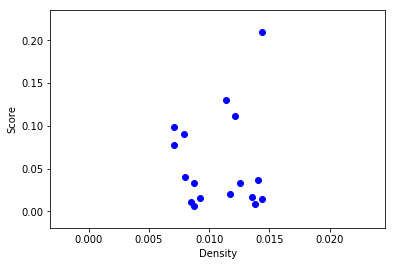

In [113]:
plt.scatter(df_sort_state.Density, df_sort_state.score, color='blue')

plt.xlabel("Density")
plt.ylabel("Score")